## Introduction

This study addresses the problem of optimizing the placement of multiple advertisements on a web banner, where the price of an ad varies based on its position on the banner. The problem is modeled as a two-dimensional orthogonal knapsack problem with a pixel-based pricing model. Given that the problem is NP-complete, a solution balancing efficiency and effectiveness is required. Experimental results demonstrate that significant improvements in advertising banner performance can be achieved by adopting position-based pricing models, thereby increasing revenue for website owners.

In [19]:
import random
import gurobipy as gb
import matplotlib.pyplot as plt
import numpy as np

 ### Description for Revenue Maximization

#### 1. Definitions and Data Generation

- **Advertisements**: $\( A = \{a_1, a_2, \ldots, a_m\} \)  $

  Set of advertisements available for placement.
  

- **Banner Dimensions**: $\( W \times H = w \times h \)$

  Width and height of the banner.
  

- **Random Widths and Heights**:  

  Randomly generated widths $\( wi \)$ and heights $\( hi \)$ for each advertisement in $\( A \)$.
  

#### 2. Sets and Combinations

- **Starting Positions**:  

  $\( Xi \)$ and $\( Yi \)$ define the possible starting columns and rows respectively for each advertisement in $\( A \)$.
  

- **Combinations (J)**:  

  $\( J \)$ is a list of tuples representing all valid combinations of advertisements, vertical positions, and horizontal positions:
  
  $\[
  J = \{(i, p, q) \mid i \in A, p \in Yi[i], q \in Xi[i]\}
  \]$
  

- **Banner Positions (K)**:  

  $\( K \)$ contains all possible positions inside the banner where an advertisement could be placed:
  
  $\[
  K = \{(r, s) \mid r \in [1, H], s \in [1, W]\}
  \]$
  

#### 3. Values and Coverage Checks

- **Values of Positions (v)**:  

  $\( v \)$ assigns a random value to each position $\( (p, q) \)$ on the banner for each advertisement:
  
  $\[
  v_{i, p, q} = \text{random value assigned to position } (p, q) \text{ for advertisement } i
  \]$
  


- **Coverage Indicator (a)**:  

  $\( a \)$ indicates whether placing advertisement $\( i \)$ at position $\( (p, q) \)$ covers position $\( (r, s) \)$ on the banner, ensuring no overlap:
  
  $\[
  a_{i, p, q, r, s} = \begin{cases} 
  1 & \text{ if } p \leq r \leq p + hi[i] - 1 \text{ and } q \leq s \leq q + wi[i] - 1 \\
  0 & \text{ otherwise}
  \end{cases}
  \]$
  


- **Advertisement Allocation (aa)**:  

  $\( aa \)$ ensures each advertisement is allocated at most once by indicating if combination $\( j \)$ corresponds to advertisement $\( i \)$:
  
  $\[
  aa_{j, i} = \begin{cases} 
  1 & \text{ if combination } j \text{ corresponds to advertisement } i \\
  0 & \text{ otherwise}
  \end{cases}
  \]$
  


#### 4. Optimization Model

- **Model Definition**:  

  The model named 'Revenue Maximization'.
  

- **Decision Variables**:  

  Binary decision variables $\( x[j] \)$ represent whether combination $\( j \)$ is selected.
  

- **Objective Function**:  

  Maximizes the total value of allocated advertisements based on $\( v \)$:
  
  $\[
  \max \sum_{j \in J} v[j] \cdot x[j]
  \]$
  

#### 5. Constraints

- **Location Constraints**:  

  Each position $\( (r, s) \)$ on the banner can be occupied by at most one advertisement:
  
  $\[
  \sum_{j \in J} a[j, k] \cdot x[j] \leq 1 \quad \forall k \in K
  \]$
  

- **Advertisement Constraints**:  

  Each advertisement in $\( A \)$ is allocated at most once:
  
  $\[
  \sum_{j \in J} aa[j, i] \cdot x[j] \leq 1 \quad \forall i \in A
  \]$



In [20]:
A = ["Mediaworld" , "Nike", "Toys"]  # Annunci
W, H = 3,3  # Larghezza e altezza banner

wi = {i: random.randint(1, W) for i in A}  # Larghezze casuali degli annunci
hi = {i: random.randint(1, H) for i in A}  # Altezze casuali degli annunci


Xi = {i: range(1, W - wi[i] + 2) for i in A}  # Possibili colonne di partenze per annuncio i 
Yi = {i: range(1, H - hi[i] + 2) for i in A} # Possibili righe di partenze per annuncio i 

J = [(i, p, q) for i in A for p in Yi[i] for q in Xi[i]]
#J è una lista di tuple che rappresentano tutte le possibili combinazioni di annunci, posizioni verticali e posizioni orizzontali valide per ogni annuncio 

K = [(r, s) for r in range(1, H + 1) for s in range(1, W + 1)]
#K contiene tutte le possibili posizioni all'interno del banner dove un annuncio potrebbe essere posizionato.

v = {(i, p, q): random.randint(1, 100) for i in A for p in Yi[i] for q in Xi[i]}
#valore di ogni banner nella posizione p e q

a = {(i, p, q, r, s): 1 if (p <= r <= p + hi[i] - 1 and q <= s <= q + wi[i] - 1) else 0
     for i in A for p in Yi[i] for q in Xi[i] for r in range(1, H + 1) for s in range(1, W + 1)}
#a[i, p, q, r, s]: Indica se l'annuncio i posizionato in (p, q) copre la posizione (r, s) sul banner. Utilizzato per assicurarsi che ogni posizione del banner non sia coperta da più di un annuncio.

aa = {(j, i): 1 if j[0] == i else 0 for j in J for i in A}
#aa[j, i]: Indica se la combinazione j (che include l'annuncio i, la riga di partenza p e la colonna di partenza q) si riferisce all'annuncio i. Utilizzato per vincolare che ogni annuncio venga posizionato al massimo una volta.

model = gb.Model('Revenue Maximization')

# Variabile di decisioni
x = model.addVars(J, vtype=gb.GRB.BINARY, name="x")

# Funzione obiettivo: Massimizzare il valore totale degli annunci allocati
model.setObjective(gb.quicksum(v[j] * x[j] for j in J), gb.GRB.MAXIMIZE)

# Vincoli:

# Ogni posizione (r, s) sul banner può essere occupata al massimo da un annuncio
for k in K:
    model.addConstr(gb.quicksum(a[j + k] * x[j] for j in J if (j + k) in a) <= 1,name=f"location_{k[0]}_{k[1]}")

# Ciascun annuncio è allocato al massimo una volta
for i in A:
    model.addConstr(gb.quicksum(aa[j, i] * x[j] for j in J) <= 1, name=f"ad_{i}")

model.update()

model.write("revenue_maximization.lp")

In [21]:
# Optimize the model
model.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.0.0 23A344)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12 rows, 12 columns and 42 nonzeros
Model fingerprint: 0xb5b705c5
Variable types: 0 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 85.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 11 rows, 11 columns, 38 nonzeros
Variable types: 0 continuous, 11 integer (11 binary)
Found heuristic solution: objective 198.0000000

Root relaxation: cutoff, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0       198.000

Annuncio Mediaworld: larghezza = 1, altezza = 3
Annuncio Nike: larghezza = 2, altezza = 1
Annuncio Toys: larghezza = 3, altezza = 1

Annunci posizionati:
Annuncio Nike: posizione (p = 2, q = 1), larghezza = 2, altezza = 1, valore = 99
Annuncio Toys: posizione (p = 3, q = 1), larghezza = 3, altezza = 1, valore = 99
Valore totale degli annunci posizionati: 198

Pixel non occupati: [(1, 1), (1, 2), (1, 3), (2, 3)]

Valori degli annunci in ogni posizione possibile:
Annuncio Mediaworld: posizione (p = 1, q = 1), valore = 55
Annuncio Mediaworld: posizione (p = 1, q = 2), valore = 36
Annuncio Mediaworld: posizione (p = 1, q = 3), valore = 54
Annuncio Nike: posizione (p = 1, q = 1), valore = 24
Annuncio Nike: posizione (p = 1, q = 2), valore = 30
Annuncio Nike: posizione (p = 2, q = 1), valore = 99
Annuncio Nike: posizione (p = 2, q = 2), valore = 52
Annuncio Nike: posizione (p = 3, q = 1), valore = 71
Annuncio Nike: posizione (p = 3, q = 2), valore = 60
Annuncio Toys: posizione (p = 1, q = 1)

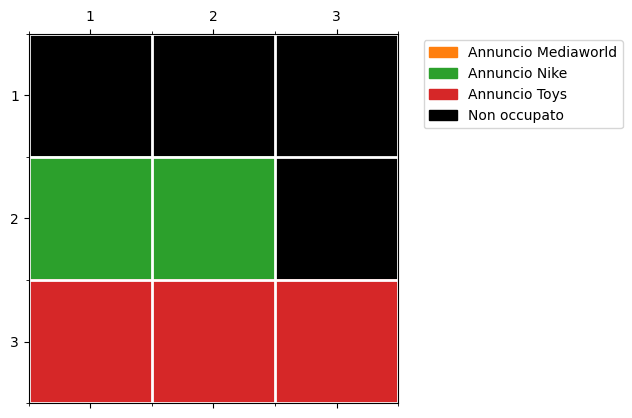

In [22]:
for i in A:
    print(f"Annuncio {i}: larghezza = {wi[i]}, altezza = {hi[i]}")
print()

# Verifica se il modello ha trovato una soluzione ottimale
if model.status == gb.GRB.OPTIMAL:

    total_revenue = 0  # Inizializza una variabile per il valore totale degli annunci posizionati
    banner = np.zeros((H, W), dtype=int)  # Matrice per rappresentare il banner

    # Mappa dei colori per gli annunci
    color_map = {ad: idx + 1 for idx, ad in enumerate(A)}
    
    print("Annunci posizionati:")
    # Itera sulle variabili decisionali x[j] per estrarre gli annunci posizionati
    for j in J:
        if x[j].x > 0.5: 
            i, p, q = j
            value = v[j]  # Valore dell'annuncio nella posizione (i, p, q)
            total_revenue += value

            # Determina i pixel occupati dall'annuncio
            for r in range(p, p + hi[i]):
                for s in range(q, q + wi[i]):
                    banner[r - 1, s - 1] = color_map[i]  # Usa l'indice dell'annuncio per il colore

            # Stampa dettagli dell'annuncio posizionato
            print(f"Annuncio {i}: posizione (p = {p}, q = {q}), larghezza = {wi[i]}, altezza = {hi[i]}, valore = {value}")
            

    # Stampa il valore totale degli annunci posizionati
    print(f"Valore totale degli annunci posizionati: {total_revenue}")
    print()

    # Inizializza una lista per tenere traccia dei pixel non occupati
    unoccupied_pixels = [(r, s) for r in range(1, H + 1) for s in range(1, W + 1)
                         if all(x[i, p, q].x <= 0.5 or not (p <= r <= p + hi[i] - 1 and q <= s <= q + wi[i] - 1)
                                for i in A for p in range(1, H - hi[i] + 2) for q in range(1, W - wi[i] + 2))]

    
    print("Pixel non occupati:", unoccupied_pixels)
    print()

    # Stampa il valore di ogni annuncio in ogni posizione possibile
    print("Valori degli annunci in ogni posizione possibile:")
    for j in J:
        i, p, q = j
        value = v[j]
        print(f"Annuncio {i}: posizione (p = {p}, q = {q}), valore = {value}")
        
    print()
    print()

    
    fig, ax = plt.subplots()

    
    colors = ['black'] + [plt.cm.tab10(color_map[ad]) for ad in A]
    cmap = plt.cm.colors.ListedColormap(colors)
    cax = ax.matshow(banner, cmap=cmap)

    
    ax.set_aspect('equal')

    # Aggiungi griglie e etichette
    ax.set_xticks(np.arange(-.5, W, 1), minor=True)
    ax.set_yticks(np.arange(-.5, H, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.set_xticks(np.arange(W))
    ax.set_yticks(np.arange(H))
    ax.set_xticklabels(np.arange(1, W+1))
    ax.set_yticklabels(np.arange(1, H+1))

    # Aggiungi una legenda
    handles = [plt.Rectangle((0, 0), 1, 1, color=cmap(color_map[ad])) for ad in A]
    labels = [f"Annuncio {ad}" for ad in A]
    handles.append(plt.Rectangle((0, 0), 1, 1, color='black'))
    labels.append('Non occupato')
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    
    plt.show()

else:
    print("Il modello non ha trovato una soluzione ottimale.")
